In [1]:
# Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pycaret.classification import *
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

## Read and Explore data

In [2]:
# Import csv files
project_dir = '../Multi-Class-Prediction-of-Cirrhosis-Outcomes/'
train_set = pd.read_csv(project_dir + 'train.csv')
test_set = pd.read_csv(project_dir + 'test.csv')

In [3]:
# Print first five rows in the trainset
train_set.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


In [4]:
# Print the shape of both the trainset and test
print(f'The shape of trainset is: {train_set.shape}')
print(f'The shape of testset is: {test_set.shape}')


The shape of trainset is: (7905, 20)
The shape of testset is: (5271, 19)


In [5]:
# Print the basic information of both the trainset and testset
print(train_set.info())
print('-----------------------------------------')
print(test_set.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7905 non-null   int64  
 1   N_Days         7905 non-null   int64  
 2   Drug           7905 non-null   object 
 3   Age            7905 non-null   int64  
 4   Sex            7905 non-null   object 
 5   Ascites        7905 non-null   object 
 6   Hepatomegaly   7905 non-null   object 
 7   Spiders        7905 non-null   object 
 8   Edema          7905 non-null   object 
 9   Bilirubin      7905 non-null   float64
 10  Cholesterol    7905 non-null   float64
 11  Albumin        7905 non-null   float64
 12  Copper         7905 non-null   float64
 13  Alk_Phos       7905 non-null   float64
 14  SGOT           7905 non-null   float64
 15  Tryglicerides  7905 non-null   float64
 16  Platelets      7905 non-null   float64
 17  Prothrombin    7905 non-null   float64
 18  Stage   

No missing values in both sets

In [6]:
# Check the data type and unique values in the trainset
data = {
    'Data_Type': train_set.dtypes,
    'Unique_Values': train_set.nunique()
}
pd.DataFrame(data)

,Data_Type,Unique_Values
id,int64,7905
N_Days,int64,461
Drug,object,2
Age,int64,391
Sex,object,2
Ascites,object,2
Hepatomegaly,object,2
Spiders,object,2
Edema,object,3
Bilirubin,float64,111


In [7]:
# Check the data type and unique values in the testset
data = {
    'Data_Type': test_set.dtypes,
    'Unique_Values': test_set.nunique()
}
pd.DataFrame(data)

,Data_Type,Unique_Values
id,int64,5271
N_Days,int64,409
Drug,object,2
Age,int64,363
Sex,object,2
Ascites,object,2
Hepatomegaly,object,2
Spiders,object,2
Edema,object,3
Bilirubin,float64,108


Clear enough, no further operations needed, and for the categorical features, both trainset and testset have the same unique values.

In [8]:
# Select the numerical columns
numerical_columns = train_set.select_dtypes(include=['number'])
numerical_features = numerical_columns.columns

# Select the categorical columns
categorical_columns = train_set.select_dtypes(include=['object'])
categorical_features = categorical_columns.columns

In [9]:
# Descriptive analysis for numerical features
train_set.describe()

,id,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000
mean,3952.000000,2030.173308,18373.146490,2.594485,350.561923,3.548323,83.902846,1816.745250,114.604602,115.340164,265.228969,10.629462,3.032511
std,2282.121272,1094.233744,3679.958739,3.812960,195.379344,0.346171,75.899266,1903.750657,48.790945,52.530402,87.465579,0.781735,0.866511
min,0.000000,41.000000,9598.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000
25%,1976.000000,1230.000000,15574.000000,0.700000,248.000000,3.350000,39.000000,834.000000,75.950000,84.000000,211.000000,10.000000,2.000000
50%,3952.000000,1831.000000,18713.000000,1.100000,298.000000,3.580000,63.000000,1181.000000,108.500000,104.000000,265.000000,10.600000,3.000000
75%,5928.000000,2689.000000,20684.000000,3.000000,390.000000,3.770000,102.000000,1857.000000,137.950000,139.000000,316.000000,11.000000,4.000000
max,7904.000000,4795.000000,28650.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,563.000000,18.000000,4.000000


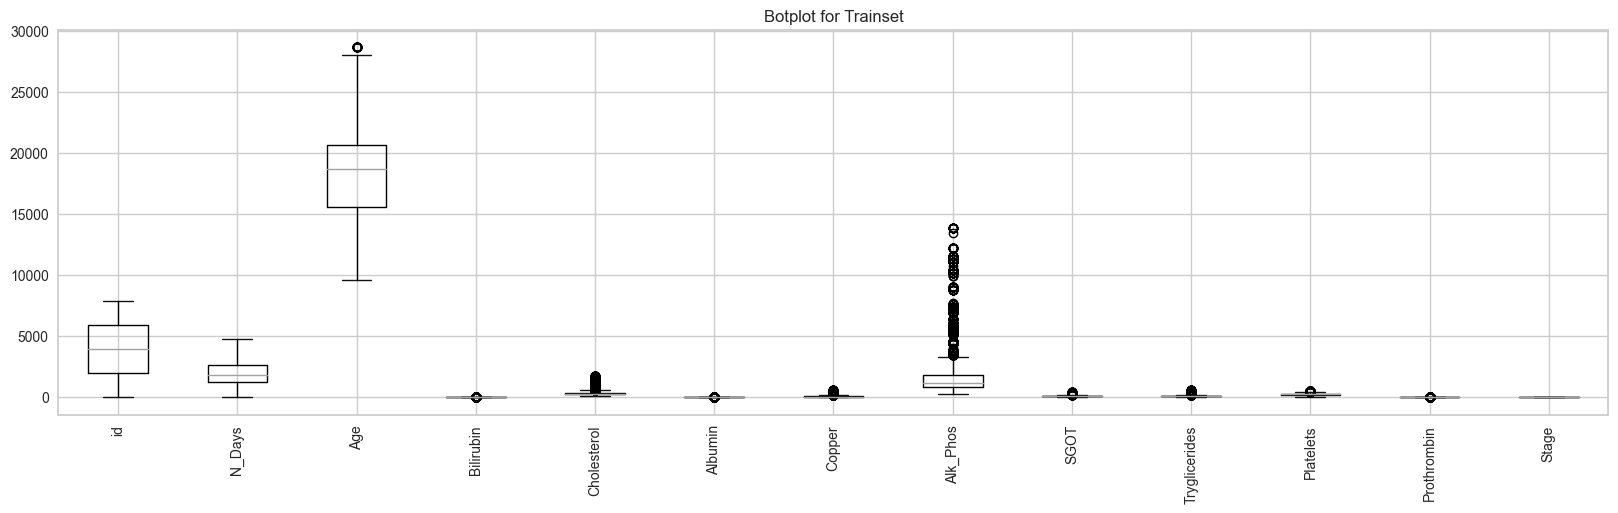

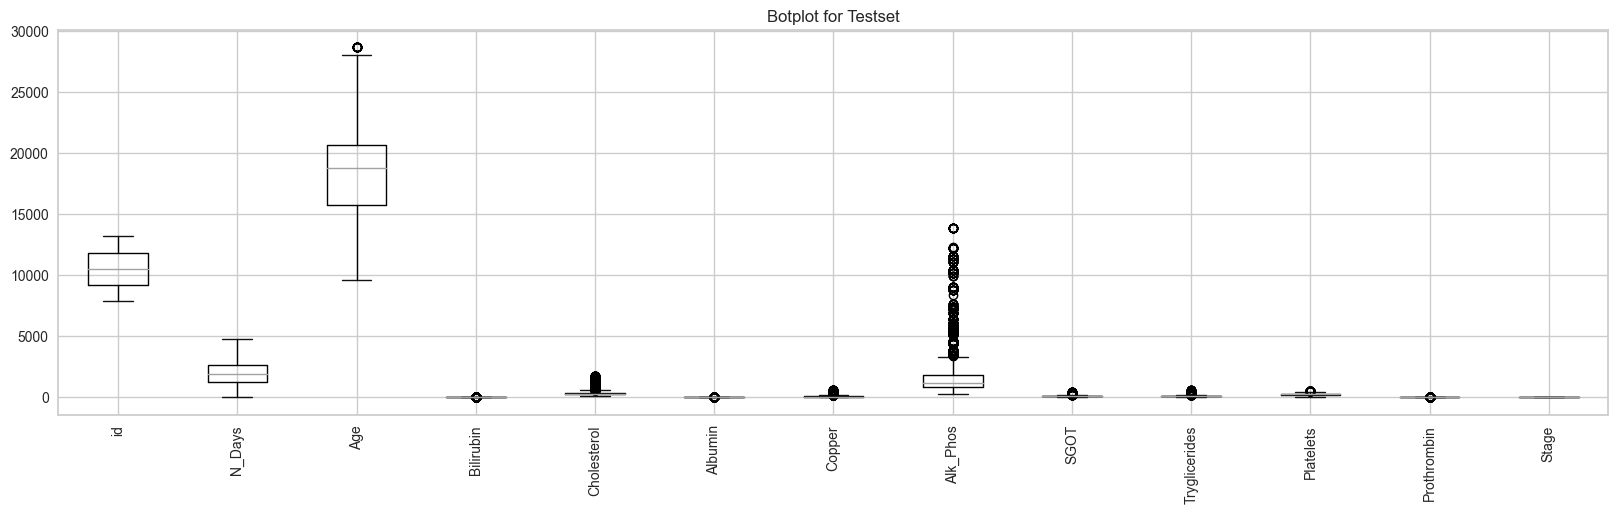

In [10]:
# Check outliers in both trainset and testset by using boxplot for numerical features
train_set.boxplot(figsize=(20,5))
plt.xticks(rotation='vertical')
plt.title('Botplot for Trainset')
plt.show()

test_set.boxplot(figsize=(20,5))
plt.xticks(rotation='vertical')
plt.title('Botplot for Testset')
plt.show()

Since both sets have similar distribution, we are not going to handle outlies here.

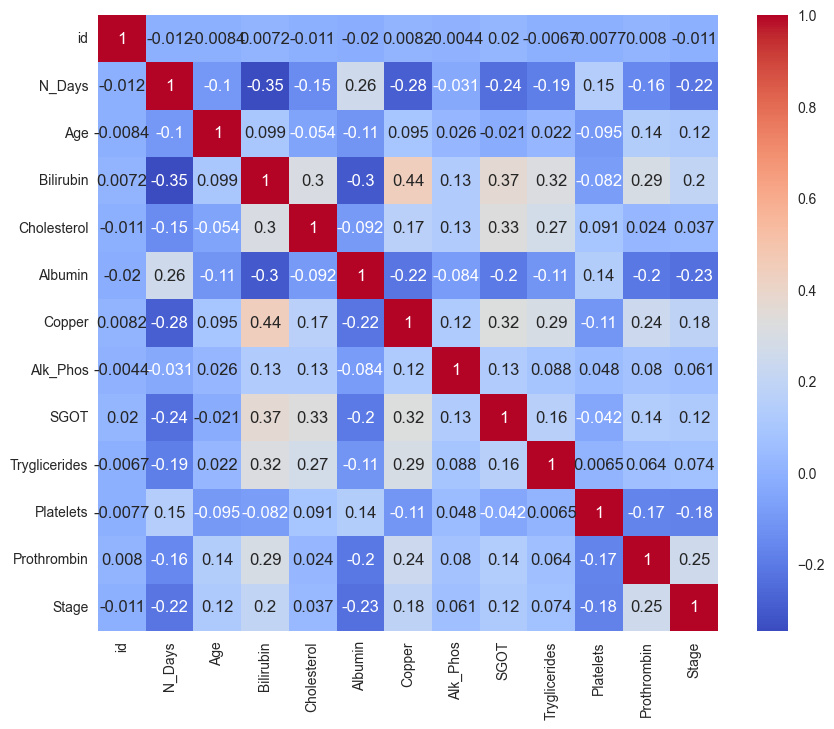

In [11]:
# Draw correlation matrix for the numerical features

# Compute the correlation matrix
correlation_matrix = numerical_columns.corr()

# Create the heatmap
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

Since no correlation coefficient is above 0.7 or below -0.7, we donot need to handle multicollinearity.

In [12]:
# Count values in categorical features

for column in categorical_features:
    print(train_set[column].value_counts())
    print('--------------------------------')

Placebo            4010
D-penicillamine    3895
Name: Drug, dtype: int64
--------------------------------
F    7336
M     569
Name: Sex, dtype: int64
--------------------------------
N    7525
Y     380
Name: Ascites, dtype: int64
--------------------------------
Y    4042
N    3863
Name: Hepatomegaly, dtype: int64
--------------------------------
N    5966
Y    1939
Name: Spiders, dtype: int64
--------------------------------
N    7161
S     399
Y     345
Name: Edema, dtype: int64
--------------------------------
C     4965
D     2665
CL     275
Name: Status, dtype: int64
--------------------------------


We can see a clear imbalance in the target variable, we may need to use techniques like *SMOTE* to handle this.

## Preprocess

In [13]:
# One-Hot encoding for categorical features
train_set = pd.get_dummies(train_set, columns = categorical_features.drop('Status'), dtype=int)
test_set = pd.get_dummies(test_set, columns = categorical_features.drop('Status'), dtype=int)

In [14]:
X = train_set[train_set.columns.drop(['id', 'Status'])]
y = train_set['Status']

In [15]:
# Standardize numerical features
sc = StandardScaler()
X = sc.fit_transform(X)
test_id = test_set['id']
test_set = sc.fit_transform(test_set.drop('id', axis=1))

In [16]:
# Compare models by using pycaret
clf = setup(X, target=y)
best_model = compare_models()
best_model

,Description,Value
0,Session id,8673
1,Target,Status
2,Target type,Multiclass
3,Target mapping,"C: 0, CL: 1, D: 2"
4,Original data shape,"(7905, 26)"
5,Transformed data shape,"(7905, 26)"
6,Transformed train set shape,"(5533, 26)"
7,Transformed test set shape,"(2372, 26)"
8,Numeric features,25
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8238,0.8942,0.8238,0.8133,0.8102,0.6190,0.6247,0.0750
gbc,Gradient Boosting Classifier,0.8216,0.9014,0.8216,0.8149,0.8112,0.6169,0.6215,0.2700
lightgbm,Light Gradient Boosting Machine,0.8207,0.8971,0.8207,0.8132,0.8120,0.6175,0.6210,0.3470
et,Extra Trees Classifier,0.8162,0.8853,0.8162,0.8061,0.8021,0.6018,0.6080,0.0500
ada,Ada Boost Classifier,0.7997,0.8187,0.7997,0.7908,0.7931,0.5777,0.5799,0.0310
lr,Logistic Regression,0.7889,0.8646,0.7889,0.7621,0.7707,0.5376,0.5456,0.3440
lda,Linear Discriminant Analysis,0.7867,0.8627,0.7867,0.7608,0.7674,0.5292,0.5398,0.0090
ridge,Ridge Classifier,0.7865,0.0000,0.7865,0.7571,0.7665,0.5274,0.5390,0.0060
svm,SVM - Linear Kernel,0.7757,0.0000,0.7757,0.7542,0.7549,0.5008,0.5161,0.0130
knn,K Neighbors Classifier,0.7752,0.8320,0.7752,0.7616,0.7599,0.5071,0.5171,0.3060


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=8673, verbose=0, warm_start=False)

Based on the result, we will create a LGBM model

## Model building

In [17]:
# Trainset and testset spliting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

In [18]:
# Build a Gradient Boosting Classfier
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

# Create a Gradient Boosting Classifier
gbc = GradientBoostingClassifier(random_state=42)

# Create RandomizedSearchCV object
random_search_gbc = RandomizedSearchCV(
    gbc, param_distributions=param_grid, n_iter=100, scoring='accuracy', cv=5, n_jobs=-1, random_state=42
)

# Fit the RandomizedSearchCV to the training data
random_search_gbc.fit(X_train, y_train)

# Get the best model
best_classifier_gbc = random_search_gbc.best_estimator_

# Make predictions using the best model
y_pred_gbc = best_classifier_gbc.predict(X_test)

# Calculate metrics
accuracy_gbc = np.mean(y_pred_gbc == y_test)
f1_gbc = f1_score(y_test, y_pred_gbc, average='weighted')

print(f"Accuracy: {accuracy_gbc}")
print(f"F1_Score: {f1_gbc}")

Accuracy: 0.8355471220746363
F1_Score: 0.8277628984819683


In [19]:
# Build a LightGBM Classifier
lgbm_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'num_leaves': [20, 31, 40],
    'max_depth': [-1, 5, 10],
    'min_child_samples': [10, 20, 30]
}

# Initialize the base model
lgbm = LGBMClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm, 
    param_distributions=lgbm_param_grid, 
    n_iter=100,
    scoring='accuracy', 
    cv=5,
    verbose=1, 
    random_state=42,
    n_jobs=-1
)

random_search_lgbm.fit(X_train, y_train)

best_model_lgbm = random_search_lgbm.best_estimator_

# Make predictions using the best model
y_pred_lgbm = best_model_lgbm.predict(X_test)

# Calculate metrics
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
f1_lgbm = f1_score(y_test, y_pred_lgbm, average='weighted')

print(f"Accuracy: {accuracy_lgbm}")
print(f"F1_Score: {f1_lgbm}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1963
[LightGBM] [Info] Number of data points in the train set: 6324, number of used features: 25
[LightGBM] [Info] Start training from score -0.458308
[LightGBM] [Info] Start training from score -3.344935
[LightGBM] [Info] Start training from score -1.101463
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Accuracy: 0.8406072106261859
F1_Score: 0.8320520862721985


The result is align with pycaret's result, now we use the model to make prediction on the testset

In [21]:
# Make prediction
y_pred_gbc_proba = best_classifier_gbc.predict_proba(test_set)
y_pred_lgbm_proba = best_model_lgbm.predict_proba(test_set)

# Create submission dataframe for lgbm model
submission_gbc = pd.DataFrame({
    'id': test_id,
    'Status_C': [max(min(p[0], 1 - 1e-15), 1e-15) for p in y_pred_gbc_proba],
    'Status_CL': [max(min(p[1], 1 - 1e-15), 1e-15) for p in y_pred_gbc_proba],
    'Status_D': [max(min(p[2], 1 - 1e-15), 1e-15) for p in y_pred_gbc_proba],
})

# Create submission dataframe for lgbm model
submission_lgbm = pd.DataFrame({
    'id': test_id,
    'Status_C': [max(min(p[0], 1 - 1e-15), 1e-15) for p in y_pred_lgbm_proba],
    'Status_CL': [max(min(p[1], 1 - 1e-15), 1e-15) for p in y_pred_lgbm_proba],
    'Status_D': [max(min(p[2], 1 - 1e-15), 1e-15) for p in y_pred_lgbm_proba],
})

# Output submission dataframe
submission_gbc.to_csv(project_dir + 'submission_gbc.csv', index=False)
submission_lgbm.to_csv(project_dir + 'submission_lgbm.csv', index=False)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
